In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
#Class for Option objects with Black-Scholes-Merton formula
class BSM:
     #classical BSM variablesite initialization
    def __init__(self, St, K,r,q,sigma,T,t):       
        self.St=St;
        self.K=K;
        self.r=r;
        self.q=q;
        self.sigma_implied=sigma;
        self.T=T;
        self.t=t;
        #self.d1=(np.log(St/(1.0*K))+(r-q)*(T-t))/(1.0*sigma*np.sqrt(T-t))+1/2.0*sigma*np.sqrt(T-t);
        #self.d2=self.d1-sigma*np.sqrt(T-t);
    
    #calculate d1
    def d1(self):
        #By conditions in function BSMEC and BSMECDelta, d1 will only be calcuated when t<T
        d1=(np.log(self.St/(1.0*self.K))+(self.r-self.q)*(self.T-self.t))/(1.0*self.sigma_implied*np.sqrt(self.T-self.t))
        d1+=1/2.0*self.sigma_implied*np.sqrt(self.T-self.t);
        return d1;
   
    #calcualte d2
    def d2(self):
        return self.d1()-self.sigma_implied*np.sqrt(self.T-self.t);
    
    #calculate Black-Scholes-Merton price for European call at time t    
    def BSMEC(self):
        if self.t>=self.T:
            return max(self.St-self.K,0);
        ans=self.St*np.exp(-self.q*(self.T-self.t))*norm.cdf(self.d1());
        ans-=self.K*np.exp(-self.r*(self.T-self.t))*norm.cdf(self.d2())
        return ans;
    
    #calculate Black-Scholes-Merton delta for European call at time t 
    def BSMECDelta(self):
        if self.t>=self.T:
            if self.St>=self.K:
                return 1;
            else:
                return 0;
        return np.exp(-self.q*(self.T-self.t))*norm.cdf(self.d1());

In [6]:
#Class for Delta Hedging MC simulation 
class DHMCSim:
    #initialization of parameters;
    #iters: iteration numbers;
    #steps: step numbers/trading days in each iteration;
    #sigma_realized: realized volatility used in MC simulation
    #BSMobj: BSM class objects
    def __init__(self,iters,steps,sigma,BSM_obj):
        self.iters=iters;
        self.steps=steps;
        self.sigma_realized=sigma;
        self.BSM_obj=BSM_obj;
    
    #calculate Accumulated daily P&L for iters numbers of iterations.
    def DHMCSim(self):
        #array storing final results for Accumulated Daily P&L;
        AccPL=np.zeros(self.iters);
        S_0=self.BSM_obj.St;
        
        #iterations to calculate Accumulated Daily P&L;
        for i in range(self.iters):
            DailyPL=np.zeros(self.steps+1);
            T=steps/365.0;
            #current time
            t_cur=0.0;
            self.BSM_obj.T=T;
            self.BSM_obj.t=t_cur;
            self.BSM_obj.St=S_0;
            S_t_cur=S_0;
            C_t_cur=self.BSM_obj.BSMEC();
            delta_t_cur=self.BSM_obj.BSMECDelta();
            #portfolio value at current time
            #portfolio=Delta*shares-Eurepean Call option
            Portfolio_t_cur=S_t_cur*delta_t_cur-C_t_cur;
            #Accured Bonds at current time
            #Accured bonds contain accrued premium/lending cost and daily delta-hedging adjustements
            Bonds_accrued_t_cur=S_t_cur*delta_t_cur-C_t_cur;
            random_num=np.random.standard_normal(self.steps);
            #print("random_num:",random_num)
            #validation purpose:
            #df = pd.DataFrame(random_num);
            #df.to_excel(excel_writer=r"C:\Users\18505\Downloads\temp.xlsx");
            
            for k in range(1,self.steps+1):
                #store old value for t, delta_portfolio and bonds_accured
                S_t_prev=S_t_cur;
                t_prev=t_cur;
                delta_t_prev=delta_t_cur;
                Portfolio_t_prev=Portfolio_t_cur;
                Bonds_accrued_t_prev=Bonds_accrued_t_cur;
                
                #calcualte new parameters in new day
                t_cur=k/365.0;
                self.BSM_obj.t=t_cur;
                #generate standard normal sample
                #random_num_t_cur=np.random.standard_normal();
                random_num_t_cur=random_num[k-1];
                #update S_t_cur based on Ito formula: MC simulation
                #S_t_cur+=(self.BSM_obj.r-self.BSM_obj.q)*S_t_cur*(t_cur-t_prev)+self.sigma_realized*S_t_cur*random_num_t_cur*np.sqrt(t_cur-t_prev);
                S_t_cur*=np.exp((self.BSM_obj.r-self.BSM_obj.q-1/2.0*(self.sigma_realized**2))*(t_cur-t_prev))
                S_t_cur*=np.exp(self.sigma_realized*random_num_t_cur*np.sqrt(t_cur-t_prev));
                self.BSM_obj.St=S_t_cur;
                C_t_cur=self.BSM_obj.BSMEC();
                delta_t_cur=self.BSM_obj.BSMECDelta();
                
                #update portfolio value at time t
                Portfolio_t_cur=S_t_cur*delta_t_cur-C_t_cur;
                
                #update Bonds_accured at time t from 3 sources: 
                #accrue interest
                Bonds_accrued_t_cur=Bonds_accrued_t_cur*np.exp(self.BSM_obj.r*(t_cur-t_prev))
                #subtract profits from delta adjustment
                Bonds_accrued_t_cur-=(delta_t_prev-delta_t_cur)*S_t_cur;
                #subtract profits from dividend payments
                Bonds_accrued_t_cur-=delta_t_prev*S_t_prev*(np.exp(self.BSM_obj.q*(t_cur-t_prev))-1.0);
                
                #update dailt P&L
                DailyPL[k]=(Portfolio_t_cur-Bonds_accrued_t_cur)-(Portfolio_t_prev-Bonds_accrued_t_prev);
                #print("k,rand_num,St,d1,Ct,Pt,Bt,PL:",k,random_num_t_cur,S_t_cur,C_t_cur,delta_t_cur,Portfolio_t_cur,Bonds_accrued_t_cur,DailyPL[k])
            #Update Accumulated P&L in steps trading days
            AccPL[i]=Portfolio_t_cur-Bonds_accrued_t_cur;                
        return AccPL;
        

In [7]:
#paramters for Delta Hedging MC simulation
iters=500;
steps=183;
sigma_realized=20.0/100;

#parameters for BSM objects
S0=4425.84;
K=4500;
r=5.0/100;
q=1.5/100;
sigma_implied=20.0/100;
T=steps/365.0;
t=0.0;

#construct BSM objects
BSM_obj=BSM(S0,K,r,q,sigma_implied,T,t);

#construct DHMCSim objects
DHMCSim_obj=DHMCSim(iters,steps,sigma_realized,BSM_obj);


In [8]:
#Q2.a
AccPL_Q_2a=DHMCSim_obj.DHMCSim();
print(AccPL_Q_2a)

[ 24.94464271  -8.34270894   7.37865303   6.85614851   5.07354365
  11.40444182  11.07983997   3.91296621  -7.42294558  23.70932814
  10.81489452   5.12995554  -9.54383728  27.39333309 -10.90213478
   5.77546321 -41.67482137   1.38420284  30.99898882  -3.4308569
  -5.66911414  27.35910815 -12.09784023  15.71875341   2.36077011
  -4.46456176  -9.35789919 -10.21357694  -0.81891219  -3.12786652
 -47.10821952   4.45288393   8.53423107  12.87952024  10.04138395
  -2.69634697  15.46266283   5.09299419  -5.60010554   1.24261273
   4.16221136 -11.10813577  -9.06901486   1.60893777  -2.30349585
  13.62561257  -0.96707012   5.9312466  -17.6633771   -3.94190913
  -6.29901695   1.55823047  11.28569863   0.46215258   0.99257898
  17.48082358  10.63714812  -0.89738976 -19.80075169 -13.04284274
  11.63196819  14.13784126  -3.26634448 -23.02517326 -42.46238858
 -57.67868616   2.03528631 -15.0455272  -26.52556105  27.3939473
  35.75466986  -2.39610789 -21.8824429   -1.24818375  17.26888485
  -9.7850739

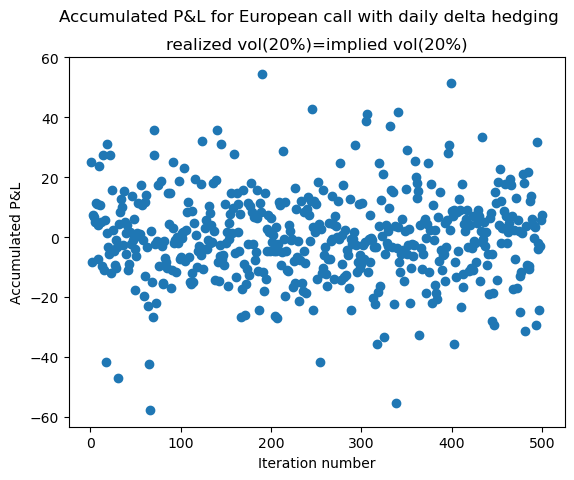

0.009158841508827379


In [9]:
plt.scatter(range(1,iters+1), AccPL_Q_2a)   
plt.xlabel('Iteration number') 
plt.ylabel('Accumulated P&L') 
plt.title("realized vol(20%)=implied vol(20%)") 
plt.suptitle('Accumulated P&L for European call with daily delta hedging')
  
# function to show the plot 
plt.show() 
print(np.average(AccPL_Q_2a))

In [10]:
#Q2.b
#initilize S0 and t for BSM objec
BSM_obj.St=S0;
BSM_obj.t=0.0;

#reset realized vol for MC simulation
sigma_realized=30.0/100;
DHMCSim_obj.sigma_realized=sigma_realized;

AccPL_Q_2b=DHMCSim_obj.DHMCSim();
print(AccPL_Q_2b)

[-203.27914655 -115.93628751 -127.14684298 -152.55381104  -29.66559094
  -62.39396851 -178.21041885 -135.99395047  -81.66958099  -62.7872737
  -91.87211764 -173.73146646 -184.22676562 -119.66728926 -185.26301476
  -96.89999549 -161.00852264  -77.21344084 -203.93139103 -113.62441986
  -88.59924098 -138.30063612 -216.29455776 -170.32896519 -143.06343852
 -213.28298695 -221.36474945 -177.06041884  -58.94393552  -96.31265364
 -116.80715565 -120.85061054 -140.80769229 -102.65757134 -222.38364638
 -127.38642117 -230.24884532  -36.96051105  -60.8189427  -125.11901469
 -219.09077083  -98.05680811  -51.84797714 -204.76656267 -148.43536047
 -115.51822861  -73.36876634 -120.21638177 -250.6951056   -88.45446014
  -53.9244526  -117.37826798 -114.227247   -240.99610716 -133.94347805
  -76.13333777  -67.64407749  -13.73101049 -203.99392111 -225.50585673
 -127.59892774 -184.79764093 -126.18971559 -171.51481461  -75.6395653
  -53.74013697 -174.27524854  -97.99365386 -129.89571705 -154.3573307
 -169.525

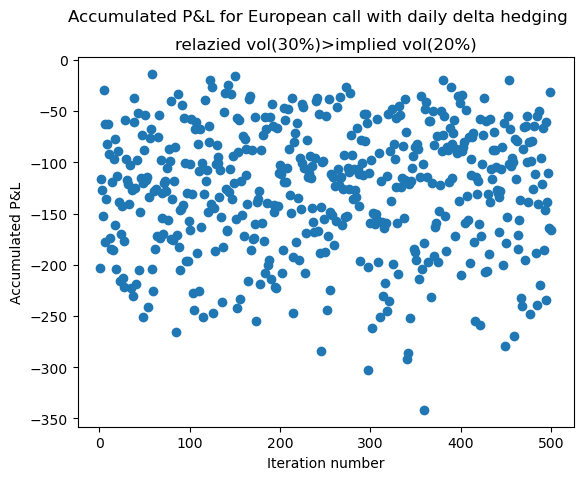

In [11]:
plt.scatter(range(1,iters+1), AccPL_Q_2b)   
plt.xlabel('Iteration number') 
plt.ylabel('Accumulated P&L') 
plt.title("relazied vol(30%)>implied vol(20%)") 
plt.suptitle('Accumulated P&L for European call with daily delta hedging')
  
# function to show the plot 
plt.show() 

In [12]:
#Q2.c
#initilize S0 and t for BSM objec
BSM_obj.St=S0;
BSM_obj.t=0.0;
BSM_obj.sigma=20.0/100;

#reset realized vol for MC simulation
sigma_realized=10.0/100;
DHMCSim_obj.sigma_realized=sigma_realized;

AccPL_Q_2c=DHMCSim_obj.DHMCSim();
print(AccPL_Q_2c)

[ 78.23964656  81.16017161 143.2180817   99.09852596 112.22062846
 152.64108877 113.65234288 116.61600282 144.20461802 170.94961872
  75.63434675 172.53385219 149.76107816  99.4156405  118.6299105
 124.58281919  70.16644148 145.25173667 152.84720633 117.7743789
 138.55692099 106.87303762 115.97935925 118.3644093  161.92336311
  66.03102154 176.1872484  150.12152729 113.08396331 147.4083003
 152.82779789 134.40775116 145.8820255  113.68200747 119.07537328
  63.39655732 152.30993525  73.49147166  61.9209102  147.47645783
 126.2870278  184.91666037 185.20592027 104.91122634  97.19773948
 197.86594362  88.65814605 171.78421067 105.12095874 156.93459316
 129.26247563  77.29869749 132.79346517 158.05427474 171.30842025
 143.13275435 170.76168424 125.1824312   94.66838568 106.69679631
 118.41332352 112.91349573  70.47416056 120.44930578 137.27218806
 113.3079311  104.05251246 158.14696539  91.28078228 184.73403739
 154.50178787  80.15565195 131.81092743 181.65785516 154.59009238
 142.10608573

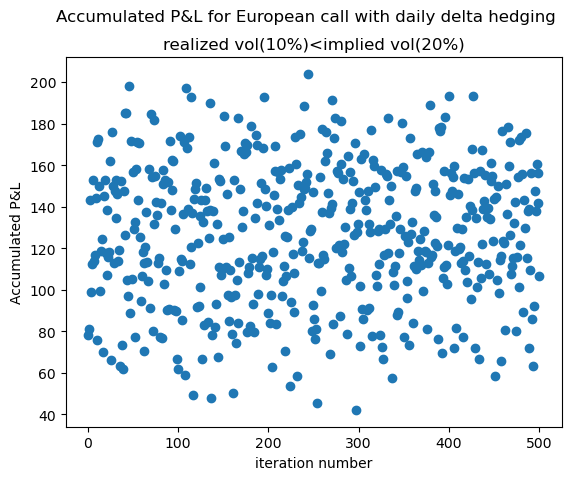

In [13]:
plt.scatter(range(1,iters+1), AccPL_Q_2c)   
plt.xlabel('iteration number') 
plt.ylabel('Accumulated P&L') 
plt.title("realized vol(10%)<implied vol(20%)") 
plt.suptitle('Accumulated P&L for European call with daily delta hedging')
  
# function to show the plot 
plt.show() 

In [14]:
# #Q3.b.1: vol=30%
# #initilize S0 and t for BSM objec
# BSM_obj.St=S0;
# BSM_obj.t=0.0;
# BSM_obj.sigma_implied=30.0/100;

# #reset realized vol for MC simulation
# sigma_realized=30.0/100;
# DHMCSim_obj.sigma_realized=sigma_realized;
# #print(BSM_obj.St,DHMCSim_obj.BSM_obj.St)

# AccPL_Q_3b_1=DHMCSim_obj.DHMCSim();
# print(AccPL_Q_3b_1)

In [15]:
# plt.scatter(range(1,iters+1), AccPL_Q_3b_1)   
# plt.xlabel('iteration number') 
# plt.ylabel('Accumulated P&L') 
# plt.title("realized vol(30%)=implied vol(30%)") 
# plt.suptitle('Accumulated P&L for European call with daily delta hedging')
  
# # function to show the plot 
# plt.show() 
# print(np.average(AccPL_Q_3b_1))

In [16]:
# #Q3.b.2: vol=10%
# #initilize S0 and t for BSM objec
# BSM_obj.St=S0;
# BSM_obj.t=0.0;
# BSM_obj.sigma_implied=10.0/100;

# #reset realized vol for MC simulation
# sigma_realized=10.0/100;
# DHMCSim_obj.sigma_realized=sigma_realized;
# #print(BSM_obj.St,DHMCSim_obj.BSM_obj.St)

# AccPL_Q_3b_2=DHMCSim_obj.DHMCSim();
# print(AccPL_Q_3b_2)

In [17]:
# plt.scatter(range(1,iters+1), AccPL_Q_3b_2)   
# plt.xlabel('iteration number') 
# plt.ylabel('Accumulated P&L') 
# plt.title("realized vol(10%)=implied vol(10%)") 
# plt.suptitle('Accumulated P&L for European call with daily delta hedging')
  
# # function to show the plot 
# plt.show() 
# print(np.average(AccPL_Q_3b_2))